BBC News Classification
==============

## Introduction:

The goal of this case study is to use different text classification techniques in order to predict a category of a given news article depending on the content written about. We will be using the publicly available database from the BBC which is made up of 2225 articles labeled under 5 categories of business, entertainment, politics, sport, and tech. This will follow the [Kaggle Competition](https://www.kaggle.com/c/learn-ai-bbc/overview) from March 2, 2019 and where the data was downloaded from. The following notebook will go through exploratory data analysis (EDA) procedure, model building and training, and comparison with supervised learning. 

#### Load Required Libraries, Model Building/Training Tools, and Visualization Tools:

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
import nltk
import re
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

#### Read in the Data: 

In [3]:
train_data = pd.read_csv(r"C:\Users\aryan\Downloads\learn-ai-bbc\BBC News Train.csv")
test_data = pd.read_csv(r"C:\Users\aryan\Downloads\learn-ai-bbc\BBC News Test.csv")

## Step 1 - Exploratory Data Analysis (EDA): 

In [4]:
# View the first 5 rows of the training data
train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


We can see that there are 3 columns of ArticleId, Text and Category. Right away we can see that the Text column includes special characters that we would like to remove. 

In [5]:
# View the first 5 rows of the testing data
test_data.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


The test data looks normal. Category is not included as it will be predicted after building and training our model. It can then be submitted to Kaggle for a score. 

In [6]:
# General information about both datasets
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


Based on the Kaggle site for the competition, the training set should have 1490 records, which we can see above to be correct.

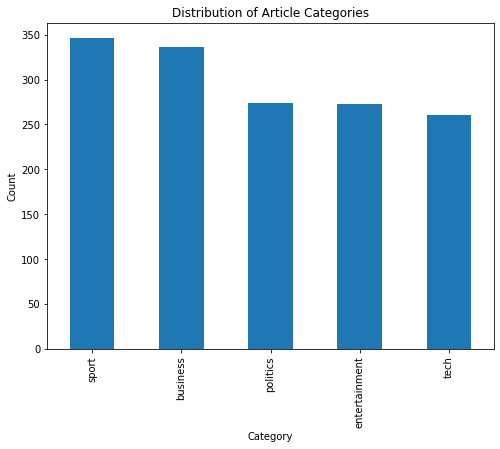

In [7]:
# Bar graph of amount of articles in each category
plt.figure(figsize=(8, 6))
train_data['Category'].value_counts().plot(kind='bar')
plt.title('Distribution of Article Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

The categories of sport and business are a bit longer than politics, entertainment, and tech. This can be something to look into  in case we want a more balanced dataset. Let us continue with further visualizations and data cleaning. 

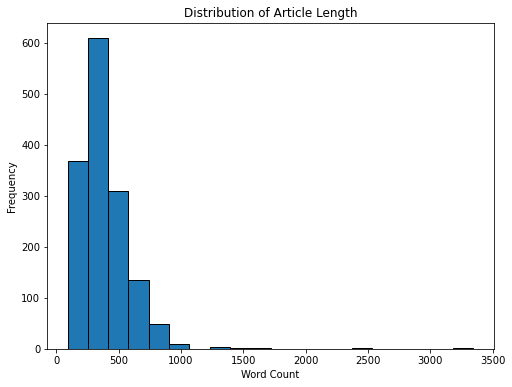

In [8]:
# Calculate the word length of articles
train_data['Article_Length'] = train_data['Text'].apply(lambda x: len(x.split()))  

# Histogram of word count to frequency
plt.figure(figsize=(8, 6))
plt.hist(train_data['Article_Length'], bins=20, edgecolor='black')
plt.title('Distribution of Article Length')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Most articles are of word length under 1000. 

In [9]:
# Check for missing values
print(train_data.isnull().sum())

# Drop rows with missing values
train_data.dropna(subset=['Text'], inplace=True)

ArticleId         0
Text              0
Category          0
Article_Length    0
dtype: int64


The missing values have been checked. 

In [10]:
# Display the first few rows of the train data
train_data.head()

,ArticleId,Text,Category,Article_Length
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301
1,154,german business confidence slides german busin...,business,325
2,1101,bbc poll indicates economic gloom citizens in ...,business,514
3,1976,lifestyle governs mobile choice faster bett...,tech,634
4,917,enron bosses in $168m payout eighteen former e...,business,355


In [11]:
# Check for duplicates in the training data
print('Duplicates in Training Data', train_data.duplicated(subset=['Text']).sum())

Duplicates in Training Data 50


In [12]:
# Remove duplicates from the training data 
train_data.drop_duplicates(subset=['Text'], inplace=True)

# Verify that duplicates have been removed
print('Duplicates removed. New shape of training data:', train_data.shape)

Duplicates removed. New shape of training data: (1440, 4)


Duplicates in the data were checked and removed. 

### Text Preprocessing:

Text preprocessing is important to do prior to applying machine learning algorithms. It allows us to reduce noise like special characters, symbols, and stop words. 

In [13]:
# Remove stop words

stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

train_data['Text'] = train_data['Text'].apply(remove_stop_words)

# Remove leading and trailing spaces from the 'Text' column
train_data['Text'] = train_data['Text'].str.strip()

# Remove extra spaces between words in the 'Text' column
def remove_extra_spaces(text):
    return ' '.join(text.split())

train_data['Text'] = train_data['Text'].apply(remove_extra_spaces)

Stop words, leading/trailing spaces, and extra spaces were removed.

In [14]:
# Remove Special Characters

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

train_data['Text'] = train_data['Text'].apply(remove_special_characters)

Special characters were removed. 

In [15]:
# Remove hyphens from the text

def remove_hyphens(text):
    return text.replace('-', '')

train_data['Text'] = train_data['Text'].apply(remove_hyphens)

Hyphens were removed. Let us view our data once more to see how it looks:

In [16]:
train_data.head()

,ArticleId,Text,Category,Article_Length
0,1833,worldcom exboss launches defence lawyers defen...,business,301
1,154,german business confidence slides german busin...,business,325
2,1101,bbc poll indicates economic gloom citizens maj...,business,514
3,1976,lifestyle governs mobile choice faster better ...,tech,634
4,917,enron bosses 168m payout eighteen former enron...,business,355


### Word Embedding: 

We will be going through some important techniques for natural language processing and information retrieval. 

##### TF-IDF Vectorization:

Term Frequency-Inverse Document Frequency (TF-IDF) is used to convert raw text data (like in our training or testing data) into a representation through numbers that can be handled by machine learning algorithms. It can pinpoint the terms inside the text by importance, which it ranks through term frequency (how often a word is brought up) and inverse document frequency (rarer words provide more information than common words). The TF-IDF matrix gives a weighted score for each word in a text and each article would be represented as a vector. This is an important step prior to model building and training. 

##### Truncated Singular Value Decomposition:
Truncated Singular Value Decomposition (SVD) is significant in reducing the complexity or dimensionality of the data, while keeping the information that is important and reducing that chance of overfitting. It works well on the matrix that comes from TF-IDF, which had a maximum number of features at 5000. Truncated SVD will further limit that to 10 components, which are representations of the previous features, and each component could find patterns within the words. This process can also reduce noise and potentially improve model performance. 

In [30]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_train = tfidf_vectorizer.fit_transform(train_data['Text'])
tfidf_test = tfidf_vectorizer.transform(test_data['Text'])

# Truncated SVD for matrix factorization
n_components = 10  # Number of latent topics
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_train = svd.fit_transform(tfidf_train)
svd_test = svd.transform(tfidf_test)

## Step 2 - Model Building, Training and Label Predicting:

We will be using K-means clustering, which is easy to implement, efficient to use, and generates clusters that are easy to interpret. It works well on real world datasets like this BBC article data. 

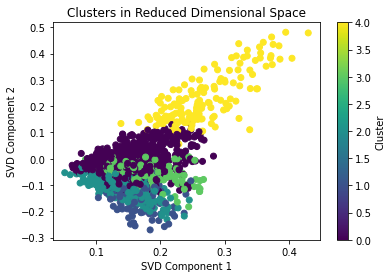

In [31]:
# We will apply K-means clustering 
kmeans = KMeans(n_clusters=5, random_state=42) 
kmeans.fit(svd_train)

# Assign cluster labels
cluster_labels = kmeans.labels_

# Visualize the clusters
plt.scatter(svd_train[:, 0], svd_train[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Clusters in Reduced Dimensional Space')
plt.colorbar(label='Cluster')
plt.show()

In [32]:
# Calculate silhouette score
silhouette_avg = silhouette_score(svd_train, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.24


In [40]:
# Define hyperparameter grid
param_grid = {'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9]} 

# Perform grid search to find the best number of clusters
best_score = -1
best_params = None
for n_clusters in param_grid['n_clusters']:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(svd_train)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(svd_train, labels)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}")
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_params = {'n_clusters': n_clusters}

# Print results
print("Best Hyperparameters:", best_params)
print("Best Silhouette Score:", best_score)


Number of clusters: 2, Silhouette Score: 0.16074058304514477
Number of clusters: 3, Silhouette Score: 0.21392948584832513
Number of clusters: 4, Silhouette Score: 0.24916412570521504
Number of clusters: 5, Silhouette Score: 0.2398372595961637
Number of clusters: 6, Silhouette Score: 0.2490875741068871
Number of clusters: 7, Silhouette Score: 0.28373009916806907
Number of clusters: 8, Silhouette Score: 0.31789008082197334
Number of clusters: 9, Silhouette Score: 0.3121761959726549
Best Hyperparameters: {'n_clusters': 8}
Best Silhouette Score: 0.31789008082197334


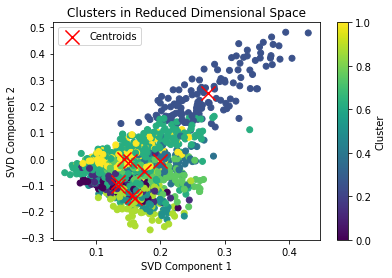

In [41]:
# Visualize the clusters
plt.scatter(svd_train[:, 0], svd_train[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, c='red', label='Centroids')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Clusters in Reduced Dimensional Space')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

Davies–Bouldin Index: 1.11534101690593


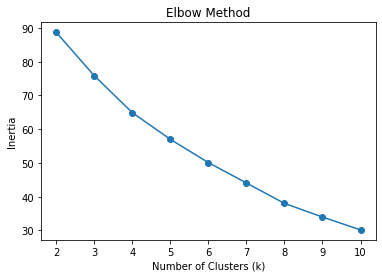

In [42]:
# Compute the Davies–Bouldin Index
db_index = davies_bouldin_score(svd_train, kmeans.labels_)
print("Davies–Bouldin Index:", db_index)

# Elbow Method for determining the optimal number of clusters
inertia_values = []
k_values = range(2, 11)  # Test different values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(svd_train)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

### Discussion:

It looks that 8 clusters for the model have the highest silhouette score. This is scored from -1 and 1, where -1 have clusters assigned incorrectly, 0 is a distance between each other that is not significant, and closer to 1 is more correctly assigned. The score of approximately 0.318 shows that clusters are better separated and have high cohesion. The hyperparameter tuning improved this over the original model, which was 5 clusters and a silhouette score of 0.240. With the Elbow Method graph, we can see that inertia slows down in decreasing around 8, which would make sense based on our score. The Davies-Bouldin Index (DBI), which evaluates the average similarity measure of each cluster to the one that is comparable to it. The score of approximately 1.115 shows a reasonable clustering quality.  


##  Building and Training Another Model:

We train a Logistic Regression model, which is a common choice for classification purposes. It is an efficient model that works well with components obtained from Truncated SVD and can handle overfitting if needed, through regularization systems. 
The labels for both the training data and test data are then predicted using the trained model. We can then move to metrics that show how our model is performing.

In [ ]:
# Train a Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(svd_train, train_data['Category'])

# Predict labels for train data
train_labels_pred = logistic_regression_model.predict(svd_train)

# Predict labels for test data
test_labels_pred = logistic_regression_model.predict(svd_test)

### Model Performance Evaluation:

We generate the accuracy score below, which calculates the proportion of correctly predicted categories in the training dataset. The confusion matrix shows a table that a summary of the actual versus predicted labels, which displays the amount of positive, false positives, true negatives, and false negatives. We can use these to see how our Logistic Regression model performed. 

In [23]:
# True labels for train data
true_labels_train = train_data['Category']

# Measure accuracy for the train data
train_accuracy = accuracy_score(true_labels_train, train_labels_pred)
print("Train Accuracy:", train_accuracy)

# Confusion matrix for the train data
train_confusion_matrix = confusion_matrix(true_labels_train, train_labels_pred)
print("Train Confusion Matrix:")
print(train_confusion_matrix)


Train Accuracy: 0.9458333333333333
Train Confusion Matrix:
[[324   1   3   1   6]
 [  4 250   3   4   2]
 [ 19   0 239   6   2]
 [  1   1   0 340   0]
 [  9   4   5   7 209]]


We plot the confusion matrix as a heatmap visualization below. 

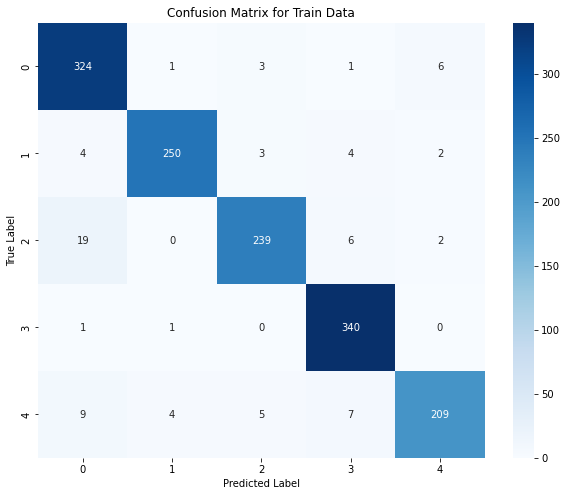

In [29]:
# Heatmap for the train data confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Train Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Create a save for the Kaggle submission. 

In [24]:
# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ArticleId': test_data['ArticleId'],
    'Category': test_labels_pred
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

### Hypertuning The Model:

We have seen the base accuracy of our model above, which achieved an accuracy of about 0.946. Let us see how changing the number of components in our Truncated SVD step can change our model’s performance. We iterate over the multiple options and train a model on each, then receive the accuracy output. 

In [51]:
# Define hyperparameters to tune
n_components_values = [5, 10, 15, 20]  # Test different component values

# Record results in a DataFrame
results_df = pd.DataFrame(columns=['n_components', 'Train Accuracy'])

# Iterate over hyperparameters
for n_components in n_components_values:
    # Truncated SVD for matrix factorization
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd_train = svd.fit_transform(tfidf_train)
    
    # Train a logistic regression model
    logistic_regression_model = LogisticRegression(max_iter=1000)
    logistic_regression_model.fit(svd_train, train_data['Category'])
    
    # Predict labels for the train data
    train_labels_pred = logistic_regression_model.predict(svd_train)
    
    # Calculate accuracy for the train data
    train_accuracy = accuracy_score(train_data['Category'], train_labels_pred)
    
    # Record the results
    results_df = results_df.append({'n_components': n_components, 'Train Accuracy': train_accuracy}, ignore_index=True)

# Display the results
print(results_df)

  n_components Train Accuracy
0          5.0       0.920833
1         10.0       0.945833
2         15.0       0.952778
3         20.0       0.954861


We see that train accuracy is increasing with more components. Let visualize it below for easier viewing.

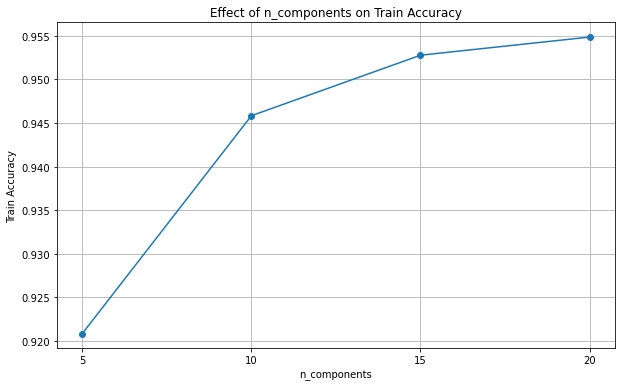

In [27]:
# Convert 'n_components' to integers
results_df['n_components'] = results_df['n_components'].astype(int)

# Line plot of components to train accuracy
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_components'], results_df['Train Accuracy'], marker='o', linestyle='-')
plt.title('Effect of n_components on Train Accuracy')
plt.xlabel('n_components')
plt.ylabel('Train Accuracy')
plt.xticks(results_df['n_components'])
plt.grid(True)
plt.show()

#### Components Discussion:

The increase of accuracy with more components in Truncated SVD could be to several reasons. There would be more information preserved from the TF-IDF matrix which could provide better classification functioning. Less components can also lead to underfitting and some complex relationships in the data could be missed by the model. We do need to be careful, as adding more components could do the opposite effect as well, and lead to overfitting. The model would perform well on the training data, but then would struggle with unseen data, which is more important. 

## Step 3 - Comparison with Supervised Training:

In [43]:
# Train a logistic regression model
logistic_regression_model_supervised = LogisticRegression(max_iter=1000)
logistic_regression_model_supervised.fit(tfidf_train, train_data['Category'])

# Predict labels for the train and test data
train_labels_pred_supervised = logistic_regression_model_supervised.predict(tfidf_train)

# Measure accuracy for the train and test data
train_accuracy_supervised = accuracy_score(train_data['Category'], train_labels_pred_supervised)

# Print the results
print("Supervised Learning - Train Accuracy:", train_accuracy_supervised)

Supervised Learning - Train Accuracy: 0.9972222222222222


In [44]:
# Compute Adjusted Rand Index (ARI)
ari = adjusted_rand_score(train_data['Category'], kmeans.labels_)
print("Adjusted Rand Index (ARI):", ari)

# Compute Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(train_data['Category'], kmeans.labels_)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 0.5342936754497585
Normalized Mutual Information (NMI): 0.6815984481560825


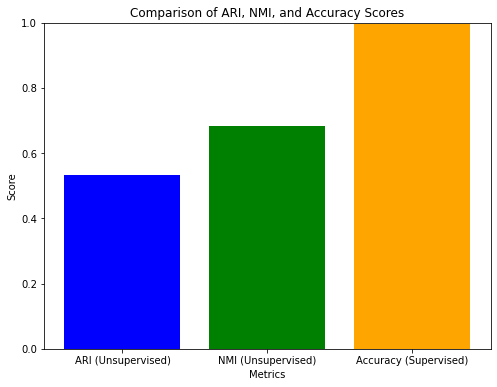

In [50]:
# Accuracy score of supervised learning
accuracy_score_supervised = 0.9972222222222222

# ARI, NMI, and accuracy scores
scores = {'ARI (Unsupervised)': 0.5342936754497585, 'NMI (Unsupervised)': 0.6815984481560825, 'Accuracy (Supervised)': accuracy_score_supervised}

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(scores.keys(), scores.values(), color=['blue', 'green', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Comparison of ARI, NMI, and Accuracy Scores')
plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1
plt.show()

### Discussion: 

We compared the unsupervised learning model with a supervised logistic regression model. Since the supervised can be measured with an accuracy score, which shows how well the model predicts the labels of the training data. A score of 0.997 is quite high and suggests that the model is correctly classifying texts into categories. 

We can compare this to the k-means clustering by using metrics that compare the clustering results with ground truth labels. Adjusted Rand Index (ARI) measures how similar clusters are between each other and ranges from 0, which is random clustering, and 1 which is the best score. There is also Normalized Mutual Information (NMI) which amounts the mutual information involving two clusters. A score of 0.534 for ARI and a score of 0.682 for MRI both relatively that the K-means clustering portrays some of the structure of the data but could be improved. The accuracy score of the logistic regression model is higher than both metrics, even though it is difficult to directly compare them. 

The supervised learning model could have used the access to labeled data during training to provide a better understanding of the data. K-means clustering can also find difficulty in complex data patterns that a supervised model would be able to handle. Even so, the silhouette score, ARI, and NMI, do not test how well the model can label articles into categories based on their text. It would be difficult to compare directly. 

#### Changing Train Data Size:

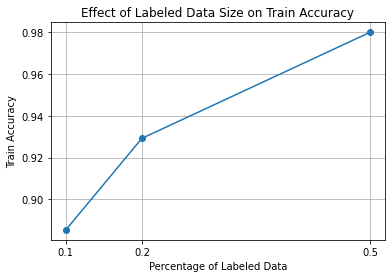

In [34]:
# Define the percentage of labeled data to include
percentages = [0.1, 0.2, 0.5]

# Initialize lists to store results
train_accuracies = []

for percentage in percentages:
    # Split the original training data into labeled and unlabeled subsets
    labeled_data, _ = train_test_split(train_data, train_size=percentage, random_state=42, stratify=train_data['Category'])

    # Preprocess the labeled data 
    labeled_data['Text'] = labeled_data['Text'].apply(remove_stop_words)
    labeled_data['Text'] = labeled_data['Text'].apply(remove_special_characters)
    labeled_data['Text'] = labeled_data['Text'].apply(remove_extra_spaces)
    labeled_data['Text'] = labeled_data['Text'].apply(remove_hyphens)

    # Transform the labeled text data using a TF-IDF vectorizer
    tfidf_labeled = tfidf_vectorizer.transform(labeled_data['Text'])

    # Train on the labeled data
    logistic_regression_model = LogisticRegression(max_iter=1000)
    logistic_regression_model.fit(tfidf_labeled, labeled_data['Category'])

    # Make predictions on the entire training data
    train_labels_pred = logistic_regression_model.predict(tfidf_train)

    # Calculate accuracy for the train data
    train_accuracy = accuracy_score(train_data['Category'], train_labels_pred)
    train_accuracies.append(train_accuracy)

# Visualize the percentage of labeled data to train accuracy 
plt.plot(percentages, train_accuracies, marker='o')
plt.title('Effect of Labeled Data Size on Train Accuracy')
plt.xlabel('Percentage of Labeled Data')
plt.ylabel('Train Accuracy')
plt.xticks(percentages)
plt.grid(True)
plt.show()

In [36]:
# Define the percentage of labeled data and train accuracies
data = {
    'Percentage of Labeled Data': percentages,
    'Train Accuracy': train_accuracies
}

# Create a DataFrame from the data
summary_df = pd.DataFrame(data)

# Display the summary table
print(summary_df)

   Percentage of Labeled Data  Train Accuracy
0                         0.1        0.885417
1                         0.2        0.929167
2                         0.5        0.979861


The table provides interesting understandings into the relationship between size of the labeled train data and performance of the model. It looks to be that including more labeled data leads to a better performance, since more information can be utilized. We do need to be careful, as using more labeled data could lead to overfitting, and the model may not perform as well on unseen data. The benefit of a model like logistic regression is that it is data efficient and less prone to overfitting. It is a simpler model and works well with high-dimensional data. Even then, unsupervised learning is often more data efficient since it does not rely on labeled data. Unsupervised learning is also usually less prone to overfitting for the same reason. 

## Conclusion:

This mini project provided the opportunity to utilize both unsupervised and supervised learning to categorize BBC news articles. We performed Exploratory Data Analysis, built and trained multiple models, discussed the results, and compared the strengths and weaknesses. There are benefits to both approaches and would depend on each specific case. Unsupervised learning can be more efficient and less prone to overfitting, but supervised learning has the benefit of incorporating labeled data to the training of a model. 

### Citations: 

Bijoy Bose. (2019). BBC News Classification. Kaggle. https://kaggle.com/competitions/learn-ai-bbc

Bird, S., Loper, E., & Klein, E. (2009). *Natural Language Processing with Python.* O’Reilly Media Inc.

Rajaraman, A., & Ullman, J. D. (2011). Data mining. In *Cambridge University Press eBooks* (pp. 1–17). https://doi.org/10.1017/cbo9781139058452.002